# Spectral magnitude envelope modelling using windowed ACF and Cepstrum, scale factors and AR model (LPC) 

Author: PhD Guillaume Fuchs <br>
Fraunhofer IIS <br>
International Audio Laboratories Erlangen <br>
Am Wolfsmantel 33, 91058 Erlangen <br>
_This handout is not supposed to be redistributed_

## 1. Intro

### 1.1 Goal

The goal of the following is to demonstrate how to model the spectral magnitude envelope using different methods and especially the autoregressive model used  in Linear Preditive Coding (LPC.)

### 1.1 Preparations 

Load the usual DSP modules.

In [1]:
#3rd party modules
from scipy.io import wavfile
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### 1.2 Windowing input speech and computing magnitude spectrum

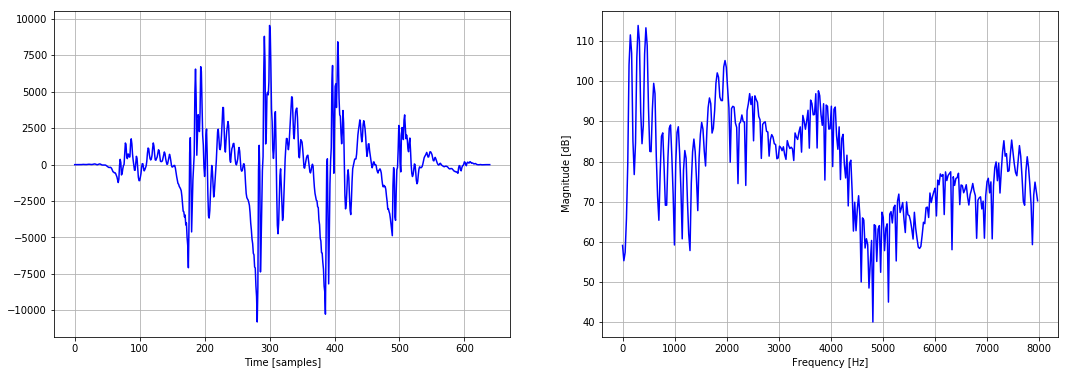

In [2]:
# file names of input speech and output speech
fname_input = 'es02.wav'
fs, in_wav = wavfile.read(fname_input)

frame_size = int(20e-3*fs)
N=frame_size*2;
x_range = range(20000,20000+N)
x=in_wav[x_range]*np.hanning(N)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(x,'b')
plt.grid()
plt.xlabel('Time [samples]')

# Log-magnitude Spectrum
X = np.fft.fft(x,N)
d = int(N/2+1)  # you only need half of the fft list
X_log=20*np.log10(abs(X[:(d)]))

# Plot
f_range=int(fs/2)*np.arange(d)/(d)
plt.subplot(122)
plt.plot(f_range,X_log,'b')
plt.grid()
plt.ylabel('Magnitude [dB]');
plt.xlabel('Frequency [Hz]');

## 2. Spectral envelope estimation through short-term ACF

*GOAL*: Get the spectral envelope through short-term ACF

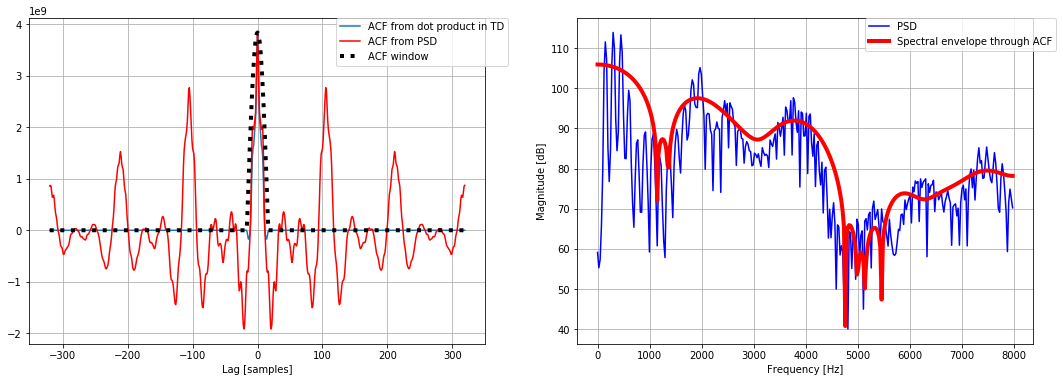

In [3]:
#ACF computation in TD using dot product (it can also be computed through PSD in FD)
r_td = np.zeros(int(N/2+1))
x_f=x.astype('float32')
for t in range(int(N/2+1)):
    r_td[t] = sum(x_f[:N-t]*x_f[t:])
r_td_sym = np.roll(np.append(r_td,r_td[-2:0:-1]),int(N/2))

# ACF computation in FD (almost equivalent, but still differs because of the circular conv. of DFT)
r_psd = np.roll(np.fft.ifft(abs(X) ** 2).real,int(N/2))

# truncate ACF: smoothing is necessary for getting spectral envelope directly from short-term ACF
order = 16; #int(N/2-1)
win_acf= (np.cos(np.pi*np.arange(-(order), order+1,dtype=float)/(2*(order+0.5)))**1)
win_acf = np.append(win_acf, np.zeros(N-win_acf.shape[0]))
win_acf = np.roll(win_acf, -order+int(N/2))

# Plot ACFs
lag_range=np.arange(-N/2,N/2)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(lag_range,r_td_sym*win_acf, label='ACF from dot product in TD')
plt.plot(lag_range,r_psd,'r',label='ACF from PSD')
plt.plot(lag_range, win_acf*np.max(r_psd),':k',linewidth=4,label='ACF window')
plt.grid()
plt.xlabel('Lag [samples]');
plt.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)

# Get FFT(ACF)
R_td = np.fft.fft(r_td_sym*win_acf,N)
R_td_log=10*np.log10(abs(R_td[:(d)]))
    
# Plot Magniture Spectrum and estinated spectral envelope
plt.subplot(122)
plt.plot(f_range,X_log,'b',label='PSD')
plt.plot(f_range,R_td_log,'r',linewidth=4,label='Spectral envelope through ACF')
plt.grid()
plt.ylabel('Magnitude [dB]');
plt.xlabel('Frequency [Hz]');
plt.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.);



## 3. Spectral envelope through short-time Cepstrum

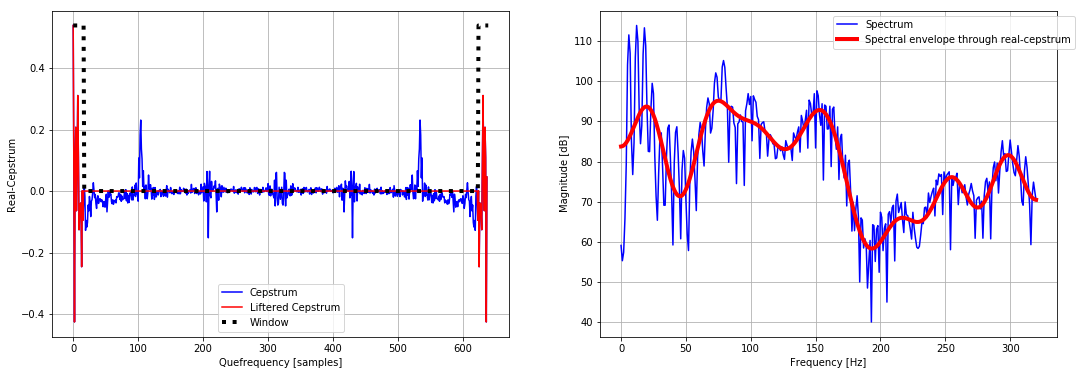

In [4]:
# Compute ST spectrum
X = np.fft.fft(x,N)

# Compute real-cepstrum using IDFT 
X_cep = np.fft.ifft(np.log(np.abs(X))).real

# Smooth ST-Cepstrum by homomorphic filtering
order_cep = int(16) #1 to N/2
win_cep = np.concatenate(([1.0], 1.0 * np.ones(order_cep), np.zeros(int(N/2)-order_cep)))
win_cep = np.append(win_cep, win_cep[-2:0:-1])
X_cep_env = np.exp(np.fft.fft(X_cep*win_cep))


# Plot Cepstrum
f=plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(X_cep[1:-1], 'b', label='Cepstrum')
X_cep_win = X_cep*win_cep
plt.plot(X_cep_win[1:-1], 'r', label='Liftered Cepstrum')
plt.plot(win_cep*np.max(X_cep[1:]), ':k',linewidth=4, label='Window')
plt.grid()
plt.ylabel('Real-Cepstrum');
plt.xlabel('Quefrequency [samples]');
plt.legend()

# Plot Log-Spectrum and resulting spectral envelope 
plt.subplot(122)
plt.plot(20*np.log10(abs(X[0:d])), 'b', label='Spectrum')
plt.plot(20*np.log10(abs(X_cep_env[0:d])),'r', linewidth=4, label='Spectral envelope through real-cepstrum')
plt.grid()
plt.ylabel('Magnitude [dB]');
plt.xlabel('Frequency [Hz]');
plt.legend(bbox_to_anchor=(1.05, 1), loc=0)
f.savefig("env_cepstrum.pdf", bbox_inches='tight')

## 4. Spectral envelope through scale factors

/home/fcs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


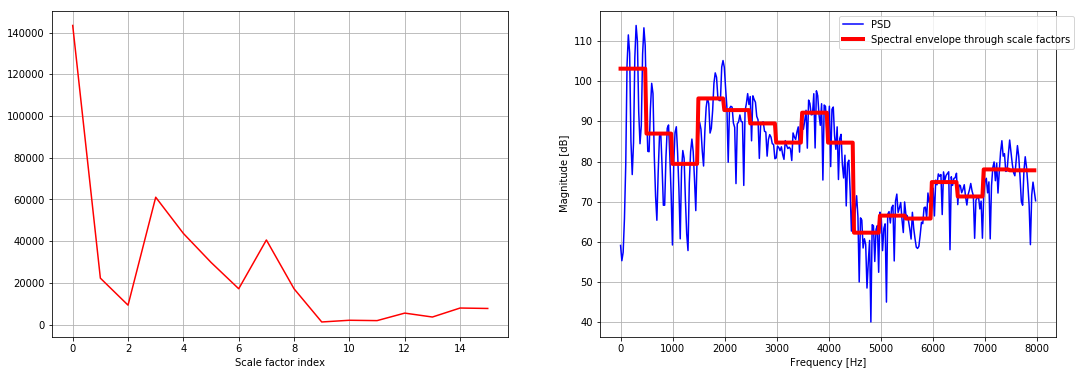

In [5]:
nb_factors = 16
band_size = int(N/(2*nb_factors))

# compute scale factors
X_bands=np.split(X[0:band_size*nb_factors],nb_factors)
X_sf = np.mean(np.abs(X_bands),axis=1)

# Extend for getting the spectral envelope
X_sf_env = np.zeros(int(N/2)+1)
for i in range(0,nb_factors):
    X_sf_env[i*band_size:(i+1)*band_size] = X_sf[i]*np.ones(X_bands[i].shape[0])
X_sf_env = np.append(X_sf_env, X_sf_env[-2:0:-1])

# Plot scale factors
f=plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(X_sf, 'r')
plt.grid()
plt.xlabel('Scale factor index');

# Plot spectrum and resulting spectral envelope
plt.subplot(122)
plt.plot(f_range, X_log, 'b', label='PSD')
plt.plot(f_range, 20*np.log10(X_sf_env[0:d]),'r', linewidth=4, label='Spectral envelope through scale factors')
plt.grid()
plt.ylabel('Magnitude [dB]');
plt.xlabel('Frequency [Hz]');
plt.legend(bbox_to_anchor=(1.05, 1))
f.savefig("env_sf.pdf", bbox_inches='tight')


## 5. Spectral envelope through AR (LPC)

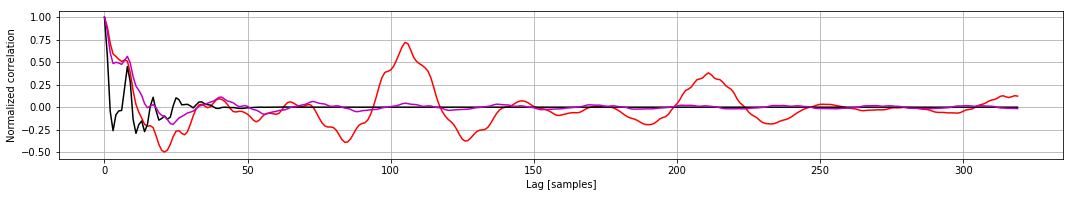

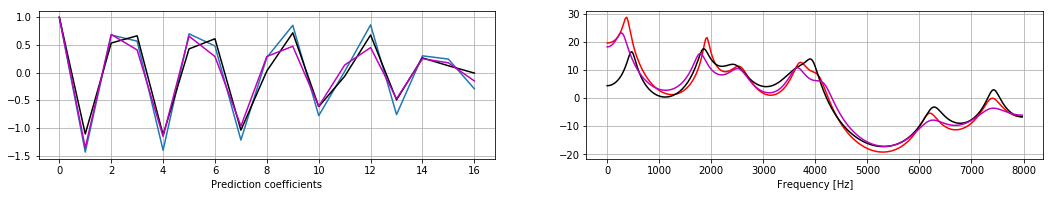

In [6]:
import lpc
from scipy.signal import lfilter

order_lpc = 16

# Get ACF from different methods
r_cep = np.roll(np.fft.ifft(abs(X_cep_env)**2).real,int(N/2))
r_sf = np.roll(np.fft.ifft(abs(X_sf_env)**2).real,int(N/2))

# Get LPC coefficienst with Levinson-Durbibn iteration
a_acf = lpc.levinson(r_td_sym[int(N/2):int(N/2)+order_lpc+2],order_lpc)
a_cep = lpc.levinson(r_cep[int(N/2):int(N/2)+order_lpc+2],order_lpc)
a_sf = lpc.levinson(r_sf[int(N/2):int(N/2)+order_lpc+2],order_lpc)

# Plot ACFs
plt.figure(figsize=(18, 6))
plt.subplot(211)
plt.plot(r_td_sym[int(N/2):]/r_td_sym[int(N/2)],'r')
plt.plot(r_cep[int(N/2):]/r_cep[int(N/2)],'k')
plt.plot(r_sf[int(N/2):]/r_sf[int(N/2)],'m')
plt.grid()
plt.ylabel('Normalized correlation');
plt.xlabel('Lag [samples]');

# Plot LPC coefficients
plt.figure(figsize=(18, 6))
plt.subplot(223)
plt.plot(a_acf[0])
plt.plot(a_cep[0],'k')
plt.plot(a_sf[0],'m')
plt.grid()
plt.xlabel('Prediction coefficients');

# Spectral Envelope from LPC
plt.subplot(224)
plt.plot(f_range, -20.0*np.log10(abs(np.fft.rfft(a_acf[0],int(N)))), 'r')
plt.plot(f_range, -20.0*np.log10(abs(np.fft.rfft(a_cep[0],int(N)))), 'k')
plt.plot(f_range, -20.0*np.log10(abs(np.fft.rfft(a_sf[0],int(N)))), 'm')
plt.grid()
plt.xlabel('Frequency [Hz]');


## 6. Linear Prediction using LPC coefficients

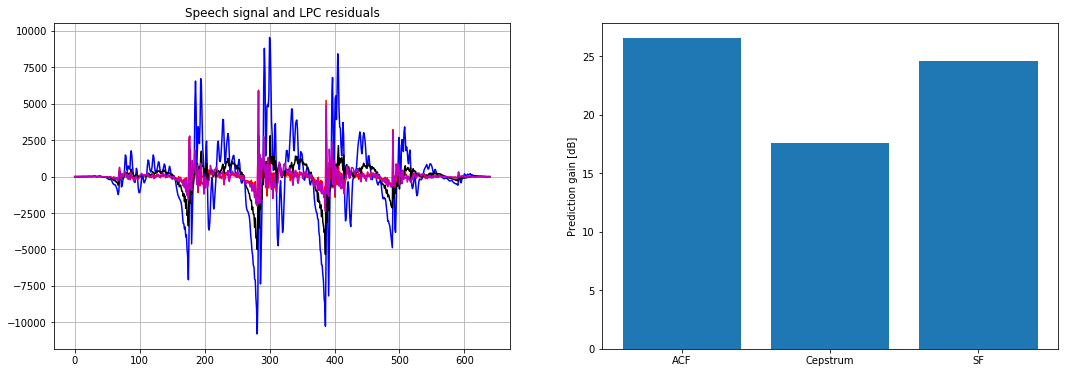

In [7]:
#Prediction of windowed signal
y_acf = lfilter(a_acf[0],[1],x)
y_cep = lfilter(a_cep[0],[1],x)
y_sf = lfilter(a_sf[0],[1],x)


plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(x,'b')
plt.plot(y_acf, 'r')
plt.plot(y_cep, 'k')
plt.plot(y_sf, 'm')
plt.grid()
plt.title('Speech signal and LPC residuals')

# Prediction gains
g_acf = np.sum(x**2)/np.sum(y_acf**2)
g_acf_db = 20*np.log10(g_acf)

g_cep = np.sum(x**2)/np.sum(y_cep**2)
g_cep_db = 20*np.log10(g_cep)

g_sf = np.sum(x**2)/np.sum(y_sf**2)
g_sf_db = 20*np.log10(g_sf)

plt.subplot(122)
x_bar = np.arange(3)
plt.bar(x_bar,[g_acf_db, g_cep_db, g_sf_db]);
plt.xticks(x_bar,('ACF', 'Cepstrum', 'SF'));
plt.ylabel('Prediction gain [dB]');

